<a href="https://colab.research.google.com/github/TaigoKuriyama/national_park_prediction/blob/master/notebook/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# read train and test data
import pandas as pd
df_train = pd.read_csv('/content/gdrive/My Drive/train.tsv', sep='\t')
df_test = pd.read_csv('/content/gdrive/My Drive/test.tsv', sep='\t')
df_test = pd.read_csv('/content/gdrive/My Drive/test.tsv', sep='\t')
df_holiday_exc_wkend = pd.read_csv('/content/gdrive/My Drive/holiday.csv')
df_nied_oyama = pd.read_csv('/content/gdrive/My Drive/nied_oyama.tsv', sep='\t')
df_nightley = pd.read_csv('/content/gdrive/My Drive/nightley.tsv', sep='\t')
df_weather = pd.read_csv('/content/gdrive/My Drive/weather.tsv', sep='\t')

In [3]:
from sklearn.cross_validation import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 特徴量エンジニアリング

In [4]:
# Feature engineering from datetime
def create_date_future(df):
    df['datetime'] = pd.to_datetime(df['datetime']) # dtypeをdatetime64に変換
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek

create_date_future(df_train)
create_date_future(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3
2,2015-01-01,日光国立公園,29714,2015,1,1,3
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3


In [5]:
# label encoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

def onehot_encdr_park(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['park'])
    le.transform(['阿寒摩周国立公園', '十和田八幡平国立公園', '日光国立公園', '伊勢志摩国立公園','大山隠岐国立公園','阿蘇くじゅう国立公園', '霧島錦江湾国立公園', '慶良間諸島国立公園']) 
    
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['park'])
    df_park = pd.DataFrame(park_onehot,columns=le.classes_)
    df = pd.concat([df,df_park],axis=1)
    return df

df_train = onehot_encdr_park(df_train)
df_test = onehot_encdr_park(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,0,0,1,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,0,0,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,0,0,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,0,0,0,0,0


In [6]:
def onehot_encdr_dayofweek(df):
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['dayofweek'])
    df_park = pd.DataFrame(park_onehot,columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    df = pd.concat([df,df_park],axis=1)
    return df

df_train = onehot_encdr_dayofweek(df_train)
df_test = onehot_encdr_dayofweek(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,0,1,0,0,0


# データから特徴量作成

## 祝日データ

In [7]:
# holiday data exclude Saturday, Sunday
df_holiday_exc_wkend['datetime'] = pd.to_datetime(df_holiday_exc_wkend['datetime'])
df_holiday_exc_wkend['dayofweek'] = df_holiday_exc_wkend['datetime'].dt.dayofweek

# dayofweekが5 or 6(土曜or日曜)の場合、holidayカラムの値を0にする
df_holiday_exc_wkend.loc[(df_holiday_exc_wkend['dayofweek'] == 5) | (df_holiday_exc_wkend['dayofweek'] == 6), 'holiday'] = 0
df_holiday_exc_wkend = df_holiday_exc_wkend[['datetime','holiday']]
df_holiday_exc_wkend = df_holiday_exc_wkend.rename(columns={'holiday': 'pub_holiday'})
df_holiday_exc_wkend.head()

,datetime,pub_holiday
0,2015-01-01,1
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0


## 積雪量データ

In [8]:
# 防災科学技術研究所 ⼤⼭鏡ヶ成積雪気象観測施設における積雪気象観測データ
# 日ごとの積雪量の平均データを作成
df_nied_oyama['日時'] = pd.to_datetime(df_nied_oyama['日時'])
df_nied_oyama['日時'] = df_nied_oyama['日時'].dt.strftime('%Y-%m-%d')
df_nied_oyama_mean = df_nied_oyama.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]
df_oyama = df_nied_oyama_mean.assign(大山隠岐国立公園=1)
df_oyama = df_oyama.rename(columns={'日時': 'datetime'})
df_oyama.head()

,datetime,積雪深(cm),気温(℃),大山隠岐国立公園
0,2015-01-01,116.029167,-6.895833,1
1,2015-01-02,137.983333,-6.362500,1
2,2015-01-03,150.050000,-3.400000,1
3,2015-01-04,137.358333,0.166667,1
4,2015-01-05,126.766667,1.812500,1


## SNS投稿カウント数 日光

In [9]:
# 前日分のカウントに変換
df_nightley['Japan_count'] = df_nightley['Japan_count'].shift(-1)
#df_nightley['Foreign_count'] = df_nightley['Foreign_count'].shift(-1)
#df_nightley['Jp_Frgn_count'] = df_nightley['Japan_count']  + df_nightley['Foreign_count'] 

# get avarage value
avg_japan = df_nightley['Japan_count'].mean()
#avg_foreign = df_nightley['Foreign_count'].mean()


df_nightley = df_nightley.rename(columns={'Japan_count': 'Jpn_cnt_ystday', 'Foreign_count':  'Freign_count_ystday'})
df_nightley = df_nightley.assign(日光国立公園	=1)

# Foreign_count_ystdayはターゲットと相関が低いので削除
df_nightley = df_nightley.drop("Freign_count_ystday", axis=1)
df_nightley.head()

,datetime,Jpn_cnt_ystday,日光国立公園
0,2016-01-01,66.0,1
1,2016-01-02,75.0,1
2,2016-01-03,50.0,1
3,2016-01-04,25.0,1
4,2016-01-05,29.0,1


## 観光客数との相関をみる
- peasonr:相関係数
- [相関係数とは](http://tomoshige-n.hatenablog.com/entry/2014/09/26/221108)

In [10]:
df_nightley['datetime'] = pd.to_datetime(df_nightley['datetime'])
df_nightley_peason= pd.merge(df_train,df_nightley,on=['日光国立公園','datetime'],how='left')
df_nightley_peason = df_nightley_peason[df_nightley_peason['日光国立公園']==1]
df_nightley_peason= df_nightley_peason[365:731]
df_nightley_peason.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Jpn_cnt_ystday
2922,2016-01-01,日光国立公園,42032,2016,1,1,4,0,0,0,...,0,0,0,0,0,0,1,0,0,66.0
2930,2016-01-02,日光国立公園,39278,2016,1,2,5,0,0,0,...,0,0,0,0,0,0,0,1,0,75.0
2938,2016-01-03,日光国立公園,29210,2016,1,3,6,0,0,0,...,0,0,0,0,0,0,0,0,1,50.0
2946,2016-01-04,日光国立公園,19673,2016,1,4,0,0,0,0,...,0,0,1,0,0,0,0,0,0,25.0
2954,2016-01-05,日光国立公園,12727,2016,1,5,1,0,0,0,...,0,0,0,1,0,0,0,0,0,29.0


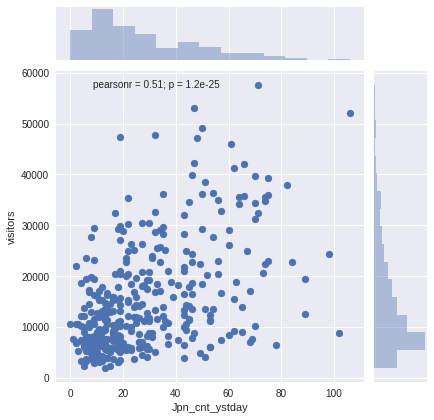

In [11]:
import  seaborn  as  sns
sns.jointplot('Jpn_cnt_ystday', 'visitors', data=df_nightley_peason)
#sns.jointplot('Foreign_count_ystday', 'visitors', data=df_nightley_peason)
#sns.jointplot('Jp_Frgn_count', 'visitors', data=df_nightley_peason)

## sin cos curve

In [0]:
# sin cos curve
N = 365 # データ数
N_ = 366
n = np.arange(365)
n_ = np.arange(366)

#  Not leap year
sin_cur_not_leap= np.sin(2*np.pi*n/N)
cos_cur_not_leap= np.cos(2*np.pi*n/N)
tan_cur_not_leap= np.tan(2*np.pi*n/N)


#sin_cur_not_leap_2 = sin_cur_not_leap * sin_cur_not_leap
#cos_cur_not_leap_2 = cos_cur_not_leap * cos_cur_not_leap
#tan_cur_not_leap_2 = tan_cur_not_leap * tan_cur_not_leap


#  leap year
sin_cur_leap= np.sin(2*np.pi*n_/N_)
cos_cur_leap= np.cos(2*np.pi*n_/N_)
tan_cur_leap= np.tan(2*np.pi*n_/N_)

#sin_cur_leap_2 = sin_cur_leap * sin_cur_leap
#cos_cur_leap_2 = cos_cur_leap * cos_cur_leap
#tan_cur_leap_2 = tan_cur_leap * tan_cur_leap

# concat for 2015, 2016
sin_cur = np.concatenate((sin_cur_not_leap, sin_cur_leap), axis=0)
cos_cur = np.concatenate((cos_cur_not_leap, cos_cur_leap), axis=0)
tan_cur = np.concatenate((tan_cur_not_leap, tan_cur_leap), axis=0)
#sin2_cur = np.concatenate((sin_cur_not_leap_2, sin_cur_leap_2), axis=0)
#cos2_cur = np.concatenate((cos_cur_not_leap_2, cos_cur_leap_2), axis=0)
#tan2_cur = np.concatenate((tan_cur_not_leap_2, tan_cur_leap_2), axis=0)

# to dataframe
df_sin_cur_train = pd.DataFrame(data=sin_cur,dtype='float')
df_cos_cur_train = pd.DataFrame(data=cos_cur,dtype='float')
df_tan_cur_train = pd.DataFrame(data=tan_cur,dtype='float')
#df_sin2_cur_train = pd.DataFrame(data=sin2_cur,dtype='float')
#df_cos2_cur_train = pd.DataFrame(data=cos2_cur,dtype='float')
#df_tan2_cur_train = pd.DataFrame(data=tan2_cur,dtype='float')

# concat for 2017
df_sin_cur_test = pd.DataFrame(data=sin_cur_not_leap,dtype='float')
df_cos_cur_test = pd.DataFrame(data=cos_cur_not_leap,dtype='float')
df_tan_cur_test = pd.DataFrame(data=tan_cur_not_leap,dtype='float')

#df_sin2_cur_test = pd.DataFrame(data=sin_cur_not_leap_2,dtype='float')
#df_cos2_cur_test = pd.DataFrame(data=cos_cur_not_leap_2,dtype='float')
#df_tan2_cur_test = pd.DataFrame(data=tan_cur_not_leap_2,dtype='float')

## Target Encoding


In [13]:
# taget encoding
#　df_train_mean = df_train.groupby('datetime',as_index=False).mean()
df_visitors_mean = df_train.groupby('park',as_index=False).mean()[['park','visitors']]
df_visitors_mean

,park,visitors
0,伊勢志摩国立公園,16314.704514
1,十和田八幡平国立公園,8890.787962
2,大山隠岐国立公園,716.424077
3,慶良間諸島国立公園,137.994528
4,日光国立公園,11324.525308
5,阿寒摩周国立公園,4422.611491
6,阿蘇くじゅう国立公園,270.445964
7,霧島錦江湾国立公園,15416.395349


## 天気データ

In [14]:
df_weather['日時'] = pd.to_datetime(df_weather['年月日'])
#df_weather_mean = df_weather.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]
df_weather.head()

,年月日,地点,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),10分間降水量の最大(mm),日照時間(時間),合計全天日射量(MJ/㎡),最深積雪(cm),...,平均蒸気圧(hPa),平均現地気圧(hPa),平均湿度(%),平均海面気圧(hPa),最小相対湿度(%),最低海面気圧(hPa),平均雲量(10分比),天気概況(昼:06時~18時),天気概況(夜:18時~翌日06時),日時
0,2015/1/1,十和田,-1.9,0.3,-2.9,5.0,1.0,2.1,NaN,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
1,2015/1/2,十和田,-3.9,-1.1,-8.0,0.0,0.0,3.3,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-02
2,2015/1/3,十和田,-4.0,-1.6,-8.9,2.0,0.5,1.4,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-03
3,2015/1/4,十和田,0.6,3.4,-1.6,0.0,0.0,2.6,NaN,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-04
4,2015/1/5,十和田,0.8,5.4,-5.1,0.0,0.0,4.0,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-05


# 作成した特徴量と学習データの結合

In [15]:
# 学習データと休日データの結合
df_merged = pd.merge(df_train,df_holiday_exc_wkend,on='datetime')
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [0]:
# 学習データと⼤⼭気象データの結合
#df_oyama['datetime'] = pd.to_datetime(df_oyama['datetime'])
#df_merged = pd.merge(df_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

In [17]:
# 学習データとSNS投稿データ(日光)の結合
df_nightley['datetime'] = pd.to_datetime(df_nightley['datetime'])
df_merged = pd.merge(df_merged,df_nightley,on=['日光国立公園','datetime'],how='left')
df_merged['Jpn_cnt_ystday'] = df_merged['Jpn_cnt_ystday'].fillna(avg_japan)
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,Jpn_cnt_ystday
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,0,1,0,0,0,1,32.441701
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,1,0,0,0,1,32.441701
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,1,0,0,0,1,32.441701
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,1,0,0,0,1,32.441701
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,1,0,0,0,1,32.441701


In [18]:
# 学習データとsin/cosカーブデータの結合
df_datetime_train = df_train[~df_train.duplicated(subset='datetime')]['datetime']
df_datetime_train = df_datetime_train.reset_index()
df_datetime_train = df_datetime_train['datetime']
df_sin_cos_tan = pd.concat([df_datetime_train,df_sin_cur_train,df_cos_cur_train,df_tan_cur_train], axis=1)
df_sin_cos_tan.columns = ['datetime', 'sin', 'cos','tan']
df_merged = pd.merge(df_merged,df_sin_cos_tan,on='datetime')
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Wed,Thu,Fri,Sat,Sun,pub_holiday,Jpn_cnt_ystday,sin,cos,tan
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0


In [0]:
# Target Encoding
#df_merged = pd.merge(df_merged,df_visitors_mean,on='park')
#df_merged.head()

In [20]:
# drop columns which is not needed
df_except_y = df_merged.drop(['year','park','visitors','datetime'], axis=1)
X_train = df_except_y.as_matrix() 
y_train = df_merged['visitors'].as_matrix()
df_except_y.head()

,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,...,Wed,Thu,Fri,Sat,Sun,pub_holiday,Jpn_cnt_ystday,sin,cos,tan
0,1,1,3,0,0,0,0,0,1,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
1,1,1,3,0,1,0,0,0,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
2,1,1,3,0,0,0,0,1,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
3,1,1,3,1,0,0,0,0,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0
4,1,1,3,0,0,1,0,0,0,0,...,0,1,0,0,0,1,32.441701,0.0,1.0,0.0


# 作成した特徴量とテストデータの結合

In [21]:
# holidayデータとのマージ
#df_test_merged = pd.merge(df_test,df_holiday,on='datetime')
df_test_merged = pd.merge(df_test,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_holiday_exc_wkend,on='datetime')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [0]:
# testデータと⼤⼭気象データの結合
#df_test_merged = pd.merge(df_test_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

In [23]:
# testデータとSNS投稿データ(日光)の結合
df_nightley['datetime'] = pd.to_datetime(df_nightley['datetime'])
df_test_merged = pd.merge(df_test_merged,df_nightley,on=['日光国立公園','datetime'],how='left')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,Jpn_cnt_ystday
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,NaN
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,0,0,0,1,0,NaN
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,39.0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,0,0,0,1,0,NaN
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,0,0,0,1,0,NaN


In [24]:
# sin/cos/tanカーブデータとのマージ
df_datetime_test = df_test[~df_test.duplicated(subset='datetime')]['datetime']
df_datetime_test = df_datetime_test.reset_index()
df_datetime_test = df_datetime_test['datetime']
df_sin_cos_test = pd.concat([df_datetime_test,df_sin_cur_test,df_cos_cur_test,df_tan_cur_test], axis=1)
df_sin_cos_test.columns =  ['datetime', 'sin', 'cos','tan']
df_test_merged = pd.merge(df_test_merged,df_sin_cos_test,on='datetime')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Wed,Thu,Fri,Sat,Sun,pub_holiday,Jpn_cnt_ystday,sin,cos,tan
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,1,0,39.0,0.0,1.0,0.0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0


In [0]:
# target encodingとのマージ
#df_test_merged = pd.merge(df_test_merged,df_visitors_mean,on='park')
#df_test_merged.head()

In [26]:
# drop columns which is not needed
df_test_merged = df_test_merged.drop(['year','park','datetime','index'], axis=1)
#df_test_merged = df_test_merged.fillna(0)
X_test = df_test_merged.as_matrix()
df_test_merged.head()

,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,...,Wed,Thu,Fri,Sat,Sun,pub_holiday,Jpn_cnt_ystday,sin,cos,tan
0,1,1,6,0,0,0,0,0,1,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0
1,1,1,6,0,1,0,0,0,0,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0
2,1,1,6,0,0,0,0,1,0,0,...,0,0,0,0,1,0,39.0,0.0,1.0,0.0
3,1,1,6,1,0,0,0,0,0,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0
4,1,1,6,0,0,1,0,0,0,0,...,0,0,0,0,1,0,NaN,0.0,1.0,0.0


# CV用モデル作成

 ## Neural Network

In [27]:
# Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train,test_size=0.5,random_state=0,shuffle=False)

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(X_train_cv, y_train_cv)

# predict
y_test_pred_dl = reg_dl.predict(X_test_cv)
y_train_pred_dl = reg_dl.predict(X_train_cv)

Using TensorFlow backend.


TypeError: ignored

In [0]:
# 評価
from sklearn.metrics import mean_absolute_error
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_test_pred_dl)))
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_train_pred_dl)))

## Support Vector Regression

In [0]:
# SVR
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train,test_size=0.5,random_state=0,shuffle=False)

# training
reg_svr.fit(X_train_cv, y_train_cv)

# predict
y_test_pred_svr= reg_svr.predict(X_test_cv)
y_train_pred_svr = reg_svr.predict(X_train_cv)

In [29]:
# 評価
from sklearn.metrics import mean_absolute_error
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_test_pred_svr)))
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_train_pred_svr)))

MAE train：6686.010449916632
MAE test：7096.706857486568


## xgboost

In [30]:
import math
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

# parametar tuning
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }

model = xgb.XGBRegressor()
cv = GridSearchCV(model,params,cv=10,n_jobs=-1)

# cross validation
from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train,test_size=0.5,random_state=0,shuffle=False)

# model
cv.fit(X_train_cv, y_train_cv)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [31]:
# predict
y_test_pred = cv.predict(X_test_cv)
y_train_pred = cv.predict(X_train_cv)

# 評価
from sklearn.metrics import mean_absolute_error
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_train_pred)))
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_test_pred)))

MAE train：1158.1524901505861
MAE test：2377.18715214925


# 結果まとめ

### sin cos追加
MAE test：1630.9984953020241  
MAE train：903.9336502896668  
提出結果：1815.2318495033333

### sin cos tan
MAE train：1179.305741077898  
MAE test：2629.263019825626  
提出結果：1,745.20888

### sin cos tan, year削除
MAE train：2045.7497492293164  
MAE test：2843.218553122352  
提出結果：1,729.58493

### sin cos tan, sin*2. cos*2, tan*2 year削除
MAE train：2059.769329007771  
MAE test：2853.8435037211093  
提出結果：1,805.52980	

### sin cos tan year削除, SNS投稿データ
MAE train：1149.2940249979576  
MAE test：2128.5665729553853  
提出結果：3260.9467285

### sin cos tan year削除, SNS投稿データ(日本のみ)
MAE train：1158.1524901505861  
MAE test：2157.12182194655   
提出結果：

### sin cos追加、曜日のone hotを削除
MAE train：1179.305741077898  
MAE test：2629.263019825626  
提出結果：1887.2631403236114  

### sin cos追加、ターゲットエンコーディングを追加
MAE train：230.22719528671817  
MAE test：3480.3254402260286  
提出結果： 6635

### 学び
- MAE trainとMAE testの差が小さいほど、提出結果もよくなる
- なので単純にMAE testが低ければいいという感じでもない

# 誤差分析
Residuals：残差(誤差の推定量)

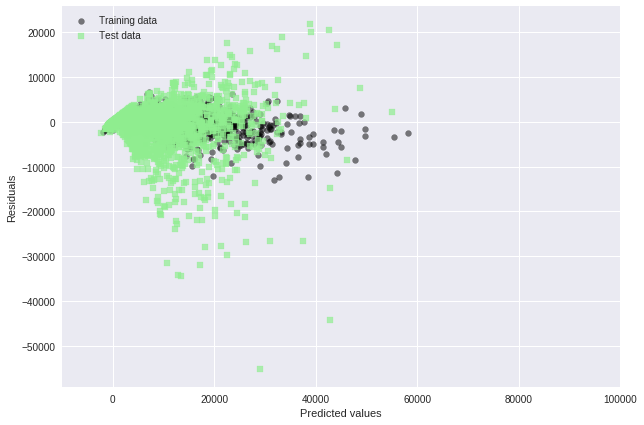

In [32]:
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train_cv, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test_cv, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
#plt.scatter(y_train_pred, y_train_cv, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
#plt.scatter(y_test_pred, y_test_cv, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-10000, 100000])
plt.show()

# 提出用モデル作成

In [0]:
# model
cv.fit(X_train, y_train)

In [0]:
# model
reg = xgb.XGBRegressor(**cv.best_params_)
reg.fit(X_train, y_train)

In [0]:
# 学習モデルの保存、読み込み
import pickle
#pickle.dump(reg, open("../model/model_19.pkl", "wb"))
#reg = pickle.load(open("../model/model_8.pkl", "rb"))

In [0]:
# future importance
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(reg.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [0]:
features =df_except_y.columns[df_except_y.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in reg._Booster.get_fscore().items()}
xgb.plot_importance(mapped)

In [0]:
# predict
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [0]:
# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_test_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit =df_submit.where(df_submit.iloc[:, [0]] > 0, 0)

In [0]:
df_submit.to_csv('submit_19.tsv',sep='\t',header=None)
files.download('submit_19.tsv')

In [0]:
# second feature matrix
X_train2 = pd.DataFrame( {'XGB': reg.predict(X_train),
     'SVR': reg_svr.predict(X_train),
    })
X_train2.tail()

In [0]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)



In [0]:
# prediction using the test set
X_test2 = pd.DataFrame( {'XGB': reg.predict(X_test),
     'SVR': reg_svr.predict(X_test)
    })

# Don't forget to convert the prediction back to non-log scale
y_pred = np.exp(reg.predict(X_test2))

submission.to_csv('houseprice.csv', index=False)

# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit =df_submit.where(df_submit.iloc[:, [0]] > 0, 0)